In [5]:
import torch
import norse
from norse.torch.functional.lif_adex import LIFAdExParameters
import norse.torch as snn
import torch.nn as nn
from tqdm import tqdm
from generate_tasks.cognitive_task import ContextDM, CompareObjects, MultyTask
from exponent_filter import ExpFilter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {("gpu (cuda)" if device.type=="cuda" else "cpu")}')

# print(neuron_parameters)
class SNNMULTYTASK(torch.nn.Module):
    def __init__(
        self, feature_size, hidden_size, output_size, neuron_parameters
    ) -> None:
        super(SNNMULTYTASK, self).__init__()
        # self.poisson = snn.PoissonEncoder(100)
        # self.lif0 = snn.LIFRecurrent(feature_size, hidden_size)
        self.alif = snn.LIFAdExRecurrent(feature_size, hidden_size, p=neuron_parameters)
        # self.lif = snn.LIFRecurrent(feature_size, hidden_size)
        self.exp_f = ExpFilter(hidden_size, output_size, 0.8)
        # self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # out, state = self.lif0(x)
        out, state = self.alif(x)
        # out = self.linear(out)
        out = self.exp_f(out)
        return (out, state)

Device: gpu (cuda)


In [6]:
import numpy as np

# 0. Create dataset


batch_size = 10
task_list = [("WorkingMemory", dict()), (("ContextDM", dict()))]
tasks = dict(task_list)
CDM_task = MultyTask(tasks, batch_size=batch_size)

# inputs, labels, ob_size, act_size = CDM_task.dataset()


feature_size, output_size = CDM_task.feature_and_act_size[0]
hidden_size = 800

# 1. model


neuron_parameters = LIFAdExParameters(
    tau_ada_inv=torch.Tensor([0.1]).to(device), alpha=50
)
model = SNNMULTYTASK(feature_size, hidden_size, output_size, neuron_parameters).to(
    device
)
with torch.no_grad():
    weights_pre_l = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights_pre_l.append((param).cpu().numpy())
            # print (name, param.data)

# 2. loss and optimizer
learning_rate = 5e-3


class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


criterion = nn.MSELoss()
criterion_test = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.8, 0.85))
running_loss = 0.0

In [7]:
# 3. train loop
for i in range(1000):
    inputs, target_outputs = CDM_task.dataset(10)
    inputs += np.random.normal(0, 0.01, size=(inputs.shape))
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, states = model(inputs)

    loss = criterion(outputs, target_outputs)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2 == 0:
        print("epoch: {:d} loss: {:0.5f}".format(i + 1, running_loss / 10))
        running_loss = 0.0
        with torch.no_grad():
            inputs, target_outputs = CDM_task.dataset()
            inputs = torch.from_numpy(inputs).type(torch.float).to(device)
            target_outputs = (
                torch.from_numpy(target_outputs).type(torch.float).to(device)
            )
            outputs, states = model(inputs)
            loss = criterion_test(outputs, target_outputs)
            print("test loss: {:0.5f}".format(loss.item()))


print("Finished Training")

KeyboardInterrupt: 

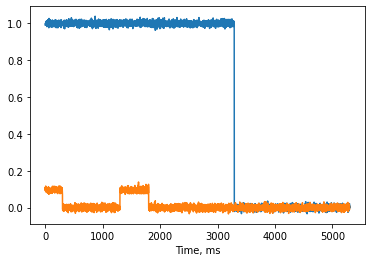

inputs.shape = (5300, 1, 2)
outputs.shape = (5300, 1, 2)


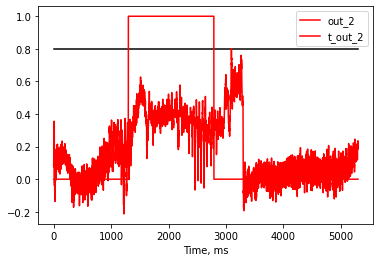

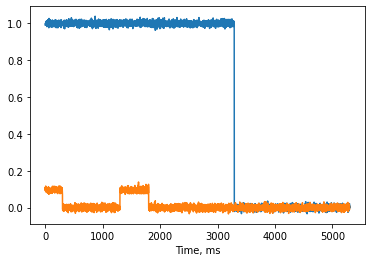

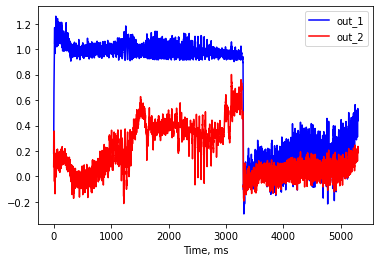

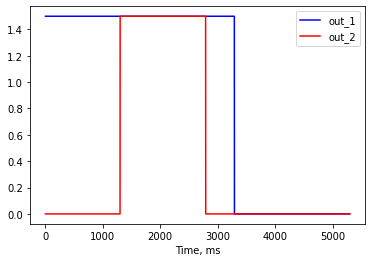

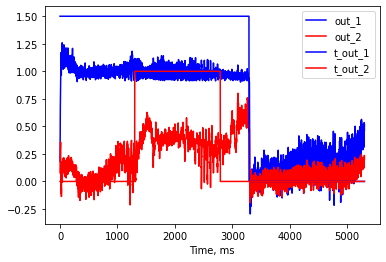

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 0. Create dataset
dt = 1e-3

batch_size = 1
CDM_task = CompareObjects(batch_size=batch_size)
inputs, labels = CDM_task.dataset(1)
inputs += np.random.normal(0, 0.01, size=(inputs.shape))
plt.plot(inputs[:, 0, 0])
plt.plot(inputs[:, 0, 1])
plt.xlabel("Time, ms")
plt.show()
plt.close()
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
feature_size, output_size = CDM_task.feature_and_act_size

# 1. model

if False:

    model = SNNMULTYTASK(feature_size, hidden_size, output_size).to(device)
    with torch.no_grad():
        for name, param in model.named_parameters():
            param.copy_(torch.from_numpy(np.load(f"./data/{name}.npy")).to(device))
# labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
with torch.no_grad():
    outputs, state = model(inputs)
    inputs = inputs.cpu().numpy()
    outputs = outputs.cpu().numpy()
    print(f"inputs.shape = {inputs.shape}")
    print(f"outputs.shape = {outputs.shape}")
    plt.plot([0, len(labels)], [np.max(outputs[:, 0, 1])] * 2, c="black")
    plt.plot(outputs[:, 0, 1], label="out_2", c="r")

    plt.plot(labels[:, 0, 1], label="t_out_2", c="r")
    plt.xlabel("Time, ms")
    plt.legend()
    plt.show()
    plt.close()
    # plt.plot(labels[:, 0, 0])
    plt.plot(inputs[:, 0, 0])
    plt.plot(inputs[:, 0, 1])
    # plt.xlim([0, 1000])
    plt.xlabel("Time, ms")
    plt.show()
    plt.close()
    # plt.plot(outputs[:, 0, 2])
    # plt.plot(outputs[:, 0, 0] + 1)
    plt.plot(outputs[:, 0, 0], label="out_1", c="b")
    plt.plot(outputs[:, 0, 1], label="out_2", c="r")
    plt.xlabel("Time, ms")
    plt.legend()
    plt.show()
    plt.close()
    plt.plot(labels[:, 0, 0] * 1.5, label="out_1", c="b")
    plt.plot(labels[:, 0, 1] * 1.5, label="out_2", c="r")
    # plt.xlim([0, 300])
    plt.xlabel("Time, ms")
    plt.legend()
    plt.show()
    plt.close()

    plt.plot(outputs[:, 0, 0], label="out_1", c="b")
    plt.plot(outputs[:, 0, 1], label="out_2", c="r")

    plt.plot(labels[:, 0, 0] * 1.5, label="t_out_1", c="b")
    plt.plot(labels[:, 0, 1], label="t_out_2", c="r")
    plt.xlabel("Time, ms")
    plt.legend()
    plt.show()
    plt.close()

In [ ]:
state.v.size()

torch.Size([1, 800])

In [ ]:
# import numpy as np
# with torch.no_grad():
# weights_after_l = []
# for name, param in model.named_parameters():
# np.save(f'./data/{name}', param.cpu())
# print (name, param.data)

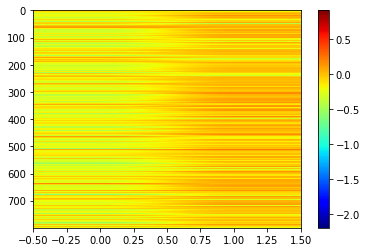

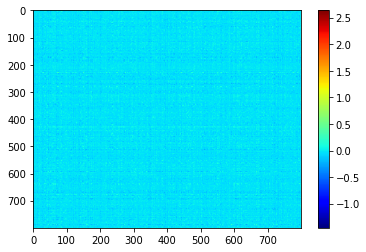

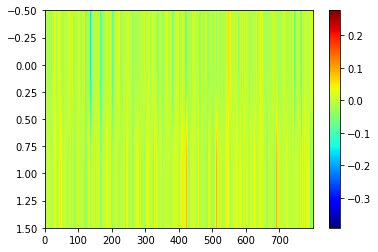

In [ ]:
with torch.no_grad():
    weights_after_l = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights_after_l.append((param).cpu().numpy())
            # print (name, param.data)

for i in range(len(weights_after_l) - 1):
    plt.imshow(weights_after_l[i] - weights_pre_l[i], aspect="auto", cmap="jet")
    plt.colorbar()
    plt.show()
    plt.close()

after


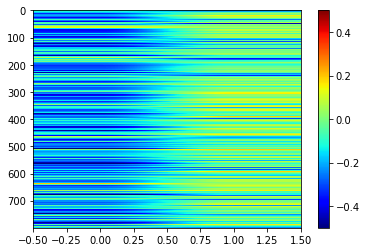

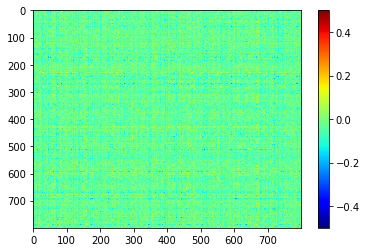

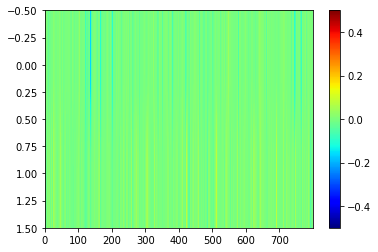

pre


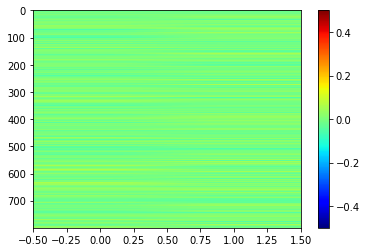

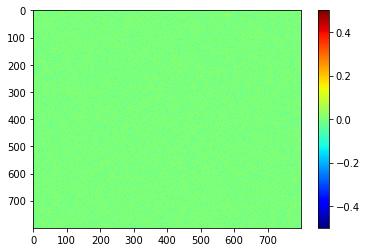

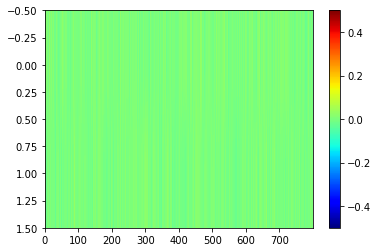

TypeError: Invalid shape (2,) for image data

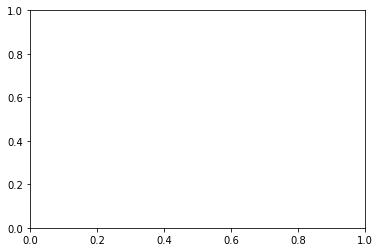

In [ ]:
print("after")
for i in range(len(weights_after_l) - 1):
    plt.imshow(weights_after_l[i], aspect="auto", cmap="jet", vmin=-0.5, vmax=0.5)
    plt.colorbar()
    plt.show()
    plt.close()
print("pre")
for i in range(len(weights_after_l)):
    plt.imshow(weights_pre_l[i], aspect="auto", cmap="jet", vmin=-0.5, vmax=0.5)
    plt.colorbar()
    plt.show()
    plt.close()

In [ ]:
for i in rage